In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define target ensembles and variables
nx       = 150
ens      = 1+np.arange(nx)
varlist   = ['FPSN','QVEGT','Jmx25Z','Vcmx25Z','SOILWATER_10CM']
forcing   = ['mcsec','FSDSVD','FSDSVI','TLAI','TBOT','RH','FSDS','RAIN','SNOW','LAISUN','LAISHA']
paramlist = ['xl','theta_ip','theta_cj','jmaxb0','wc2wjb0','jmaxb1']
ixpft = 7 #BDT

In [3]:
# setting up the file path structures
edir      = '/glade/scratch/djk2120/UMBens/'
eprefix   = 'US-UMB_GPPcap_LHC'
def ens_path(ee):
    return glob.glob(edir+eprefix+str(ee).zfill(4)+'*.h1.*')[0]

pdir      = '/glade/u/home/djk2120/umbcap/params/paramfiles/done/'
pprefix   = 'US-UMB_GPPcap_LHC'
def param_path(ee):
    return pdir+pprefix+str(ee).zfill(4)+'.nc'

In [4]:
paths = [ens_path(ee) for ee in ens]
ensdim   = xr.DataArray(ens, dims='ens', name='ens')
%time ds = xr.concat([xr.open_dataset(p)[varlist] for p in paths],dim=ensdim)

CPU times: user 21.5 s, sys: 5.96 s, total: 27.5 s
Wall time: 1min 6s


In [5]:
bdir     = '/glade/scratch/djk2120/drdfclm50d89wspinsp_US-UMB_I1PtClm50SpRsGs/run/'
basecase = bdir+'drdfclm50d89wspinsp_US-UMB_I1PtClm50SpRsGs.clm2.h1.2005-01-01-00000.nc'
b = xr.open_dataset(basecase)
for v in forcing:
    ds[v] = b[v]

In [6]:
paths = [param_path(ee) for ee in ens]
%time ds_list = [xr.open_dataset(p) for p in paths]

CPU times: user 29.6 s, sys: 1.85 s, total: 31.5 s
Wall time: 35.7 s


In [7]:
first = True
nldir= '/glade/scratch/djk2120/UMBens/'

x = np.zeros(nx)
for v in paramlist:
    if first:
        first = False
        print(str(ds_list[0]['pftname'][ixpft].values)[2:-1])
    if v in ds_list[0]:
        ndims = len(ds_list[0][v].shape)  #how many dims for this param?
        for i in range(nx):
            if ndims==0:
                x[i] = ds_list[i][v]
            if ndims==1:
                x[i] = ds_list[i][v][ixpft]
            if ndims==2:
                x[i] = ds_list[i][v][0,ixpft]
    else:
        #namelist variables handled separately
        x = xr.open_dataset(nldir+v+'.nc')[v].values
    ds[v] = xr.DataArray(data=x,dims='ens').copy(deep=True)

broadleaf_deciduous_temperate_tree      


In [8]:
ds

<xarray.Dataset>
Dimensions:         (ens: 150, lndgrid: 1, time: 87649)
Coordinates:
  * ens             (ens) int64 1 2 3 4 5 6 7 8 ... 144 145 146 147 148 149 150
  * time            (time) datetime64[ns] 2005-01-01 ... 2015-01-01
Dimensions without coordinates: lndgrid
Data variables:
    FPSN            (ens, time, lndgrid) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    QVEGT           (ens, time, lndgrid) float32 0.0 1.662732e-22 ... 0.0
    Jmx25Z          (ens, time, lndgrid) float32 85.0 85.0 85.0 ... 85.0 85.0
    Vcmx25Z         (ens, time, lndgrid) float32 50.0 50.0 50.0 ... 50.0 50.0
    SOILWATER_10CM  (ens, time, lndgrid) float32 27.822624 ... 44.36474
    mcsec           (time) int32 ...
    FSDSVD          (time, lndgrid) float32 ...
    FSDSVI          (time, lndgrid) float32 ...
    TLAI            (time, lndgrid) float32 ...
    TBOT            (time, lndgrid) float32 ...
    RH              (time, lndgrid) float32 ...
    FSDS            (time, lndgrid) float32 ...
  

In [28]:
gpp_ens = 1.0368*ds['FPSN'].groupby('ens').mean(dim=xr.ALL_DIMS).load()


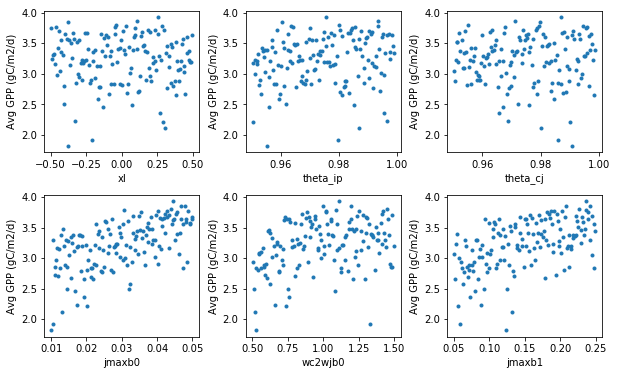

In [10]:
plt.figure(figsize=[10,6])
i = 0
for v in paramlist:
    i +=1
    plt.subplot(2,3,i)
    plt.plot(ds[v],gpp_ens,'.')
    plt.ylabel('Avg GPP (gC/m2/d)')
    plt.xlabel(v)
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

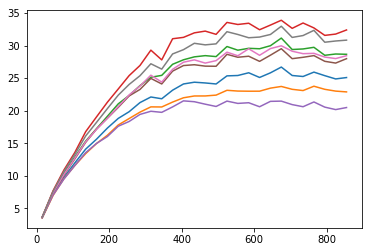

In [11]:
ix1 = np.logical_or(ds['time.month']==6,ds['time.month']==7)
f = ds['FSDS'].values.ravel()
fvals = np.arange(30)*30
fv = 0.5*(fvals[1:]+fvals[:-1])
nf = fvals.size-1
x = np.zeros(nf)

for ee in 1+np.arange(8):
    g = ds['FPSN'].sel(ens=ee)
    for i in range(nf):
        ix2 = np.logical_and(f>fvals[i],f<=fvals[i+1])
        ix  = np.logical_and(ix1,ix2)
        x[i] = np.quantile(g[ix],0.95)
    plt.plot(fv,x)

In [21]:
ds['FPSN'].sel(ens=24).mean()

<xarray.DataArray 'FPSN' ()>
array(3.663821, dtype=float32)
Coordinates:
    ens      int64 24

In [22]:
gpp24 = ds['FPSN'].sel(ens=24)
gpp24[:] = 0
gpp24.mean()

<xarray.DataArray 'FPSN' ()>
array(0., dtype=float32)
Coordinates:
    ens      int64 24

In [23]:
ds['FPSN'].sel(ens=24).mean()

<xarray.DataArray 'FPSN' ()>
array(0., dtype=float32)
Coordinates:
    ens      int64 24

In [24]:
gpp26 = ds['FPSN'].sel(ens=26).copy(deep=True)
gpp26[:] = 0
gpp26.mean()

<xarray.DataArray 'FPSN' ()>
array(0., dtype=float32)
Coordinates:
    ens      int64 26

In [25]:
ds['FPSN'].sel(ens=26).mean()

<xarray.DataArray 'FPSN' ()>
array(2.277898, dtype=float32)
Coordinates:
    ens      int64 26

In [241]:
#what's the value at 200?
f = ds['FSDS'].values.ravel()
ix1 = np.logical_or(ds['time.month']==6,ds['time.month']==7)
ix2 = np.logical_and(f>190,f<=210)
ix = np.logical_and(ix1,ix2)
f200 = np.array([np.quantile(ds['FPSN'].sel(ens=ee)[ix],0.95) for ee in ens])

ix3 = np.logical_and(f>585,f<=615)
ix = np.logical_and(ix1,ix3)
f600 = np.array([np.quantile(ds['FPSN'].sel(ens=ee)[ix],0.95) for ee in ens])

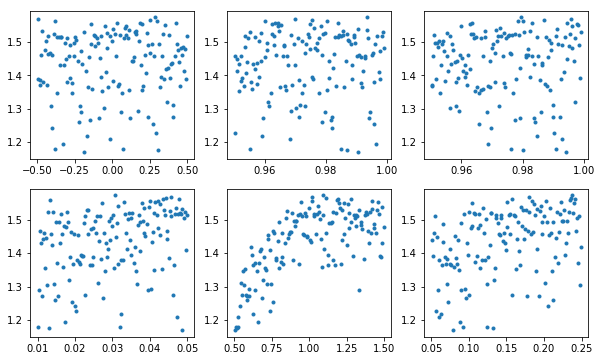

In [244]:
i = 0
plt.figure(figsize=[10,6])
for v in paramlist:
    i += 1
    plt.subplot(2,3,i)
    plt.plot(ds[v],f600/f200,'.')

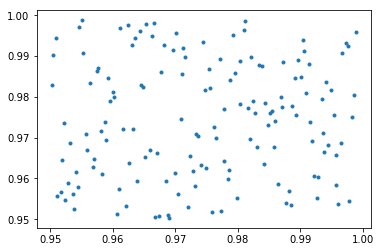

In [247]:
plt.plot(ds['theta_ip'],ds['theta_cj'],'.')